In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm


from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids

# from pomegranate import BayesianNetwork
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.sampling import BayesianModelSampling

#from sdv.single_table import TVAE, CTGAN
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
data = pd.read_csv('imp_final_df.csv')

# Display the first few rows of the dataset to understand its structure


print('originail shape:', data.shape)

data.head()


originail shape: (2827876, 21)


,Average Packet Size,Packet Length Std,Packet Length Variance,Packet Length Mean,Total Length of Bwd Packets,Subflow Bwd Bytes,Destination Port,Avg Bwd Segment Size,Bwd Packet Length Mean,Init_Win_bytes_forward,...,Total Length of Fwd Packets,Max Packet Length,Bwd Packet Length Max,Init_Win_bytes_backward,Fwd Packet Length Max,Fwd Packet Length Mean,Avg Fwd Segment Size,Flow IAT Max,Flow Bytes/s,target
0,9.0,0.0,0.0,6.0,0,0,54865,0.0,0.0,33,...,12,6,0,-1,6,6.0,6.0,3,4.000000e+06,0
1,9.0,0.0,0.0,6.0,6,6,55054,6.0,6.0,29,...,6,6,6,256,6,6.0,6.0,109,1.100917e+05,0
2,9.0,0.0,0.0,6.0,6,6,55055,6.0,6.0,29,...,6,6,6,256,6,6.0,6.0,52,2.307692e+05,0
3,9.0,0.0,0.0,6.0,6,6,46236,6.0,6.0,31,...,6,6,6,329,6,6.0,6.0,34,3.529412e+05,0
4,9.0,0.0,0.0,6.0,0,0,54863,0.0,0.0,32,...,12,6,0,-1,6,6.0,6.0,3,4.000000e+06,0


In [3]:

X = data.drop(columns=['target'])
y = data['target']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [4]:

# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Save the synthetic dataset in a separate dataframe
df_ros = pd.DataFrame(X_ros, columns=X_train.columns)
df_ros['target'] = y_ros


# Display the first few rows of the synthetic dataset
print(df_ros.shape)
df_ros.head()


(3179848, 21)


,Average Packet Size,Packet Length Std,Packet Length Variance,Packet Length Mean,Total Length of Bwd Packets,Subflow Bwd Bytes,Destination Port,Avg Bwd Segment Size,Bwd Packet Length Mean,Init_Win_bytes_forward,...,Total Length of Fwd Packets,Max Packet Length,Bwd Packet Length Max,Init_Win_bytes_backward,Fwd Packet Length Max,Fwd Packet Length Mean,Avg Fwd Segment Size,Flow IAT Max,Flow Bytes/s,target
0,51.750000,8.763561,7.680000e+01,41.400000,102,102,53,51.000000,51.000000,-1,...,70,51,51,-1,35,35.00,35.00,104,864321.608000,0
1,1083.272727,2912.631456,8.483422e+06,993.000000,11595,11595,80,2319.000000,2319.000000,0,...,315,10147,10147,235,303,52.50,52.50,83200000,141.394519,1
2,7.500000,0.000000,0.000000e+00,6.000000,18,18,56474,6.000000,6.000000,26280,...,6,6,6,29920,6,6.00,6.00,157,144578.313300,0
3,0.000000,0.000000,0.000000e+00,0.000000,0,0,35370,0.000000,0.000000,175,...,0,0,0,310,0,0.00,0.00,52,0.000000,0
4,426.000000,794.660485,6.314853e+05,414.166667,11490,11490,80,604.736842,604.736842,8192,...,3420,2920,2920,38,2034,213.75,213.75,10000000,319.354037,0


In [5]:
df_ros.to_csv('df_ros.csv', index = False)

In [6]:

# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

df_smote = pd.DataFrame(X_smote, columns=X_train.columns)
df_smote['target'] = y_smote

print(df_smote.shape)
df_smote.head()

(3179848, 21)


,Average Packet Size,Packet Length Std,Packet Length Variance,Packet Length Mean,Total Length of Bwd Packets,Subflow Bwd Bytes,Destination Port,Avg Bwd Segment Size,Bwd Packet Length Mean,Init_Win_bytes_forward,...,Total Length of Fwd Packets,Max Packet Length,Bwd Packet Length Max,Init_Win_bytes_backward,Fwd Packet Length Max,Fwd Packet Length Mean,Avg Fwd Segment Size,Flow IAT Max,Flow Bytes/s,target
0,51.750000,8.763561,7.680000e+01,41.400000,102,102,53,51.000000,51.000000,-1,...,70,51,51,-1,35,35.00,35.00,104,864321.608000,0
1,1083.272727,2912.631456,8.483422e+06,993.000000,11595,11595,80,2319.000000,2319.000000,0,...,315,10147,10147,235,303,52.50,52.50,83200000,141.394519,1
2,7.500000,0.000000,0.000000e+00,6.000000,18,18,56474,6.000000,6.000000,26280,...,6,6,6,29920,6,6.00,6.00,157,144578.313300,0
3,0.000000,0.000000,0.000000e+00,0.000000,0,0,35370,0.000000,0.000000,175,...,0,0,0,310,0,0.00,0.00,52,0.000000,0
4,426.000000,794.660485,6.314853e+05,414.166667,11490,11490,80,604.736842,604.736842,8192,...,3420,2920,2920,38,2034,213.75,213.75,10000000,319.354037,0


In [7]:
df_smote.to_csv('df_smote.csv', index = False)

In [8]:

# ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

df_adasyn = pd.DataFrame(X_adasyn, columns=X_train.columns)
df_adasyn['target'] = y_adasyn

print(df_adasyn.shape)
df_adasyn.head()

(3172878, 21)


,Average Packet Size,Packet Length Std,Packet Length Variance,Packet Length Mean,Total Length of Bwd Packets,Subflow Bwd Bytes,Destination Port,Avg Bwd Segment Size,Bwd Packet Length Mean,Init_Win_bytes_forward,...,Total Length of Fwd Packets,Max Packet Length,Bwd Packet Length Max,Init_Win_bytes_backward,Fwd Packet Length Max,Fwd Packet Length Mean,Avg Fwd Segment Size,Flow IAT Max,Flow Bytes/s,target
0,51.750000,8.763561,7.680000e+01,41.400000,102,102,53,51.000000,51.000000,-1,...,70,51,51,-1,35,35.00,35.00,104,864321.608000,0
1,1083.272727,2912.631456,8.483422e+06,993.000000,11595,11595,80,2319.000000,2319.000000,0,...,315,10147,10147,235,303,52.50,52.50,83200000,141.394519,1
2,7.500000,0.000000,0.000000e+00,6.000000,18,18,56474,6.000000,6.000000,26280,...,6,6,6,29920,6,6.00,6.00,157,144578.313300,0
3,0.000000,0.000000,0.000000e+00,0.000000,0,0,35370,0.000000,0.000000,175,...,0,0,0,310,0,0.00,0.00,52,0.000000,0
4,426.000000,794.660485,6.314853e+05,414.166667,11490,11490,80,604.736842,604.736842,8192,...,3420,2920,2920,38,2034,213.75,213.75,10000000,319.354037,0


In [9]:
df_adasyn.to_csv('df_adasyn.csv', index = False)

In [10]:

# Cluster Centroids
cc = ClusterCentroids(random_state=42)
X_cc, y_cc = cc.fit_resample(X_train, y_train)

df_cc = pd.DataFrame(X_cc, columns=X_train.columns)
df_cc['target'] = y_cc


print(df_cc.shape)
df_cc.head()

(779178, 21)


,Average Packet Size,Packet Length Std,Packet Length Variance,Packet Length Mean,Total Length of Bwd Packets,Subflow Bwd Bytes,Destination Port,Avg Bwd Segment Size,Bwd Packet Length Mean,Init_Win_bytes_forward,...,Total Length of Fwd Packets,Max Packet Length,Bwd Packet Length Max,Init_Win_bytes_backward,Fwd Packet Length Max,Fwd Packet Length Mean,Avg Fwd Segment Size,Flow IAT Max,Flow Bytes/s,target
0,19.133333,1.938061e+01,4.377667e+02,14.416667,4,4,437,1.000000e+00,1.000000e+00,294,...,46,40,1,0,39,15.444444,15.444444,125,2.960912e+05,0
1,617.000000,3.562251e+02,1.268963e+05,411.333333,0,0,62709,0.000000e+00,2.842171e-14,228,...,617,617,0,-1,617,308.500000,308.500000,0,6.170000e+08,0
2,55.500000,5.684342e-14,-2.910383e-11,37.000000,0,0,443,2.842171e-14,-5.684342e-14,33304,...,74,37,0,-1,36,37.000000,37.000000,64060281,1.155162e+00,0
3,2068.000000,1.188764e+03,1.413160e+06,1378.666667,0,0,34814,0.000000e+00,0.000000e+00,256,...,2071,2065,0,-1,2065,1035.500000,1035.500000,1,2.070000e+09,0
4,2068.000000,1.188764e+03,1.413160e+06,1378.666667,0,0,25033,0.000000e+00,0.000000e+00,16425,...,2071,2065,0,-1,2065,1035.500000,1035.500000,2,1.040000e+09,0


In [11]:
df_cc.to_csv('df_cc.csv', index = False)

In [12]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_train)
X_gmm, y_gmm = gmm.sample(n_samples=len(X_train))

df_gmm = pd.DataFrame(X_gmm, columns=X_train.columns)
df_gmm['target'] = y_gmm


print(df_gmm.shape)
df_gmm.head()


c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\mixture\_base.py:437: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


(1979513, 21)


,Average Packet Size,Packet Length Std,Packet Length Variance,Packet Length Mean,Total Length of Bwd Packets,Subflow Bwd Bytes,Destination Port,Avg Bwd Segment Size,Bwd Packet Length Mean,Init_Win_bytes_forward,...,Total Length of Fwd Packets,Max Packet Length,Bwd Packet Length Max,Init_Win_bytes_backward,Fwd Packet Length Max,Fwd Packet Length Mean,Avg Fwd Segment Size,Flow IAT Max,Flow Bytes/s,target
0,285.862649,86.401964,3.969497e+05,249.532865,1.032796e+06,1.031768e+06,58269.293758,291.985645,291.987743,-9756.763455,...,-27616.825350,-62.929384,-238.920805,139.674726,-63.173686,-11.264593,-11.264601,-1.786931e+07,-2.781397e+07,0
1,385.426209,529.662281,6.418775e+05,359.374226,2.423721e+06,2.422509e+06,25195.315886,613.469225,613.470222,16580.649395,...,31992.250311,1374.455444,1648.392261,-3509.088585,-567.803909,18.481271,18.481666,2.878418e+07,1.583891e+06,0
2,216.655836,545.043914,1.819112e+06,190.397016,6.414956e+06,6.415879e+06,58658.185118,-180.311266,-180.311898,21373.306699,...,26506.577121,1714.474113,270.905003,10712.896861,1621.079336,475.426548,475.426188,1.071253e+07,1.045064e+07,0
3,-269.787427,-481.356273,-1.674408e+06,-276.759832,-3.413665e+06,-3.413003e+06,52470.442625,12.489435,12.489053,8453.099177,...,1224.224548,-1369.083502,-292.415530,10704.848018,-539.053188,-495.752974,-495.752520,2.445660e+07,5.981550e+07,0
4,74.195487,336.736253,1.476933e+06,91.013890,3.541145e+06,3.541384e+06,32249.738834,404.185126,404.183234,2022.213581,...,-8439.572522,1081.058700,1001.381551,-2130.332086,-318.699348,-101.775368,-101.776254,1.519173e+07,-6.861804e+07,0


In [13]:
df_gmm.to_csv('df_gmm.csv', index = False)

In [14]:
data.target.value_counts()

target
0    2271320
1     556556
Name: count, dtype: int64

In [5]:
# Bayesian Network

# Learn the structure of the Bayesian Network
hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))

# Create a BayesianNetwork model from the learned structure
bn = BayesianNetwork(best_model.edges())

# After learning the initial structure with HillClimbSearch
all_variables = set(data.columns)
learned_variables = set([var for edge in best_model.edges() for var in edge])

# Identify missing variables
missing_variables = all_variables - learned_variables

# Add missing variables to the model as independent nodes
for variable in missing_variables:
    bn.add_node(variable)

# Now fit the Bayesian Network with all variables included
bn.fit(data, estimator=MaximumLikelihoodEstimator)
# Generating synthetic data
num_samples = data.shape[0]  # Number of synthetic data points to generate
synthetic_data = bn.simulate(num_samples, seed=np.random.seed(42))

# Convert the generated data into a DataFrame
df_bn = pd.DataFrame(synthetic_data)
df_bn.to_csv('df_bn.csv', index = False)
df_bn.head()


  0%|          | 0/1000000 [00:00<?, ?it/s]c:\Users\USTB\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\reshape\reshape.py:143: RuntimeWarning: overflow encountered in scalar multiply
  num_cells = num_rows * num_columns
  0%|          | 0/1000000 [00:00<?, ?it/s]


IndexError: index 46605168 is out of bounds for axis 0 with size 46468936

In [16]:
# TVAE

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['target'])

# Define metadata for the dataset
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)

# TVAE
tvae = TVAESynthesizer(metadata)
tvae.fit(train_data)
synthetic_data = tvae.sample(len(data))
X_tvae = synthetic_data.drop(columns='target').values
y_tvae = synthetic_data['target'].values



df_tvae = pd.DataFrame(X_tvae, columns=X.columns)
df_tvae['target'] = y_tvae

df_tvae.to_csv('df_tvae.csv', index = False)
print(df_tvae.shape)
df_tvae.head()


INFO:sdv.metadata.single_table:Detected metadata:
INFO:sdv.metadata.single_table:{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        " Average Packet Size": {
            "sdtype": "numerical"
        },
        " Packet Length Std": {
            "sdtype": "numerical"
        },
        " Packet Length Variance": {
            "sdtype": "numerical"
        },
        " Packet Length Mean": {
            "sdtype": "numerical"
        },
        " Total Length of Bwd Packets": {
            "sdtype": "numerical"
        },
        " Subflow Bwd Bytes": {
            "sdtype": "numerical"
        },
        " Destination Port": {
            "sdtype": "numerical"
        },
        " Avg Bwd Segment Size": {
            "sdtype": "numerical"
        },
        " Bwd Packet Length Mean": {
            "sdtype": "numerical"
        },
        "Init_Win_bytes_forward": {
            "sdtype": "numerical"
        },
        " Subflow Fwd Bytes": {
            "sdtype":

(2827876, 21)


,Average Packet Size,Packet Length Std,Packet Length Variance,Packet Length Mean,Total Length of Bwd Packets,Subflow Bwd Bytes,Destination Port,Avg Bwd Segment Size,Bwd Packet Length Mean,Init_Win_bytes_forward,...,Total Length of Fwd Packets,Max Packet Length,Bwd Packet Length Max,Init_Win_bytes_backward,Fwd Packet Length Max,Fwd Packet Length Mean,Avg Fwd Segment Size,Flow IAT Max,Flow Bytes/s,target
0,724.485825,1395.700329,2.735768e+06,755.195459,11223.0,10106.0,0.0,1932.720618,1932.542977,155.0,...,332.0,4352.0,4352.0,190.0,339.0,49.501243,49.315081,64005.0,4.064917e+05,1
1,0.068660,0.000000,0.000000e+00,0.528820,0.0,6.0,59330.0,0.058704,0.080545,187.0,...,0.0,0.0,0.0,1282.0,1.0,0.000000,0.000000,13327.0,-3.006785e+03,0
2,56.948598,0.000000,0.000000e+00,79.540963,0.0,40.0,6641.0,1.109522,4.516250,-1.0,...,565.0,1741.0,5.0,9290.0,33.0,3.107841,3.317966,51697.0,1.210189e+07,0
3,204.318437,0.000000,1.220041e+03,102.098358,91.0,143.0,60.0,133.212250,135.436152,19.0,...,54.0,149.0,152.0,0.0,43.0,43.604664,43.943635,10383.0,1.423021e+06,0
4,245.488124,0.000000,2.512150e+05,173.906935,938.0,1165.0,65.0,590.282550,319.862303,47.0,...,307.0,210.0,2242.0,-1.0,60.0,78.612037,69.138252,100582758.0,-2.009314e+03,0


In [4]:
# CTGAN
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['target'])
# Define metadata for the dataset
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)


# CTGAN
ctgan = CTGANSynthesizer(metadata)
ctgan.fit(train_data)

synthetic_data = ctgan.sample(len(data))
X_ctgan = synthetic_data.drop(columns='target').values
y_ctgan = synthetic_data['target'].values

df_ctgan = pd.DataFrame(X_ctgan, columns=X_train.columns)
df_ctgan['target'] = y_ctgan
df_ctgan.to_csv('df_ctgan.csv', index = False)

df_ctgan.head()


INFO:sdv.metadata.single_table:Detected metadata:
INFO:sdv.metadata.single_table:{
    "columns": {
        " Average Packet Size": {
            "sdtype": "numerical"
        },
        " Packet Length Std": {
            "sdtype": "numerical"
        },
        " Packet Length Variance": {
            "sdtype": "numerical"
        },
        " Packet Length Mean": {
            "sdtype": "numerical"
        },
        " Total Length of Bwd Packets": {
            "sdtype": "numerical"
        },
        " Subflow Bwd Bytes": {
            "sdtype": "numerical"
        },
        " Destination Port": {
            "sdtype": "numerical"
        },
        " Avg Bwd Segment Size": {
            "sdtype": "numerical"
        },
        " Bwd Packet Length Mean": {
            "sdtype": "numerical"
        },
        "Init_Win_bytes_forward": {
            "sdtype": "numerical"
        },
        " Subflow Fwd Bytes": {
            "sdtype": "numerical"
        },
        "Total Length of

,Average Packet Size,Packet Length Std,Packet Length Variance,Packet Length Mean,Total Length of Bwd Packets,Subflow Bwd Bytes,Destination Port,Avg Bwd Segment Size,Bwd Packet Length Mean,Init_Win_bytes_forward,...,Total Length of Fwd Packets,Max Packet Length,Bwd Packet Length Max,Init_Win_bytes_backward,Fwd Packet Length Max,Fwd Packet Length Mean,Avg Fwd Segment Size,Flow IAT Max,Flow Bytes/s,target
0,874.983519,3077.865971,1.031084e+07,796.577584,11471.0,9437.0,210.0,2920.722019,2922.757881,217.0,...,48.0,8716.0,8761.0,175.0,28.0,5.260500,4.213638,74498335.0,1050.273378,1
1,0.000000,0.018245,2.757686e+02,0.000000,0.0,0.0,292.0,0.000000,0.000000,208.0,...,0.0,0.0,0.0,226.0,0.0,0.000000,0.000000,34047.0,-2797.838215,0
2,254.474118,395.254060,2.061832e+05,330.455836,5575.0,7438.0,624.0,1394.868767,539.503872,64913.0,...,1450.0,1447.0,1457.0,5060.0,464.0,82.249081,290.997897,57556.0,64905.940918,0
3,25.095304,27.818680,4.699752e+02,43.467282,38.0,209.0,115.0,77.382145,39.790883,23.0,...,75.0,84.0,74.0,-1.0,36.0,38.553551,37.938525,19058311.0,858.469169,0
4,871.688630,1644.769445,2.220756e+06,913.939469,8154.0,9178.0,173.0,1480.117867,1373.911786,-1.0,...,511.0,4339.0,4342.0,238.0,537.0,75.730072,99.665491,86034667.0,4892.149570,1


## CTGAN execution time 3511m 55.6 s = 58.53 hours = 2.5 days

In [7]:
# data loading
df = pd.read_csv("imp_final_df.csv")
df_ros = pd.read_csv("df_ros.csv")
df_smote = pd.read_csv("df_smote.csv")
df_adasyn = pd.read_csv("df_adasyn.csv")
df_cc = pd.read_csv("df_cc.csv")
df_gmm = pd.read_csv("df_gmm.csv")
df_tvae = pd.read_csv("df_tvae.csv")
df_ctgan = pd.read_csv("df_ctgan.csv")

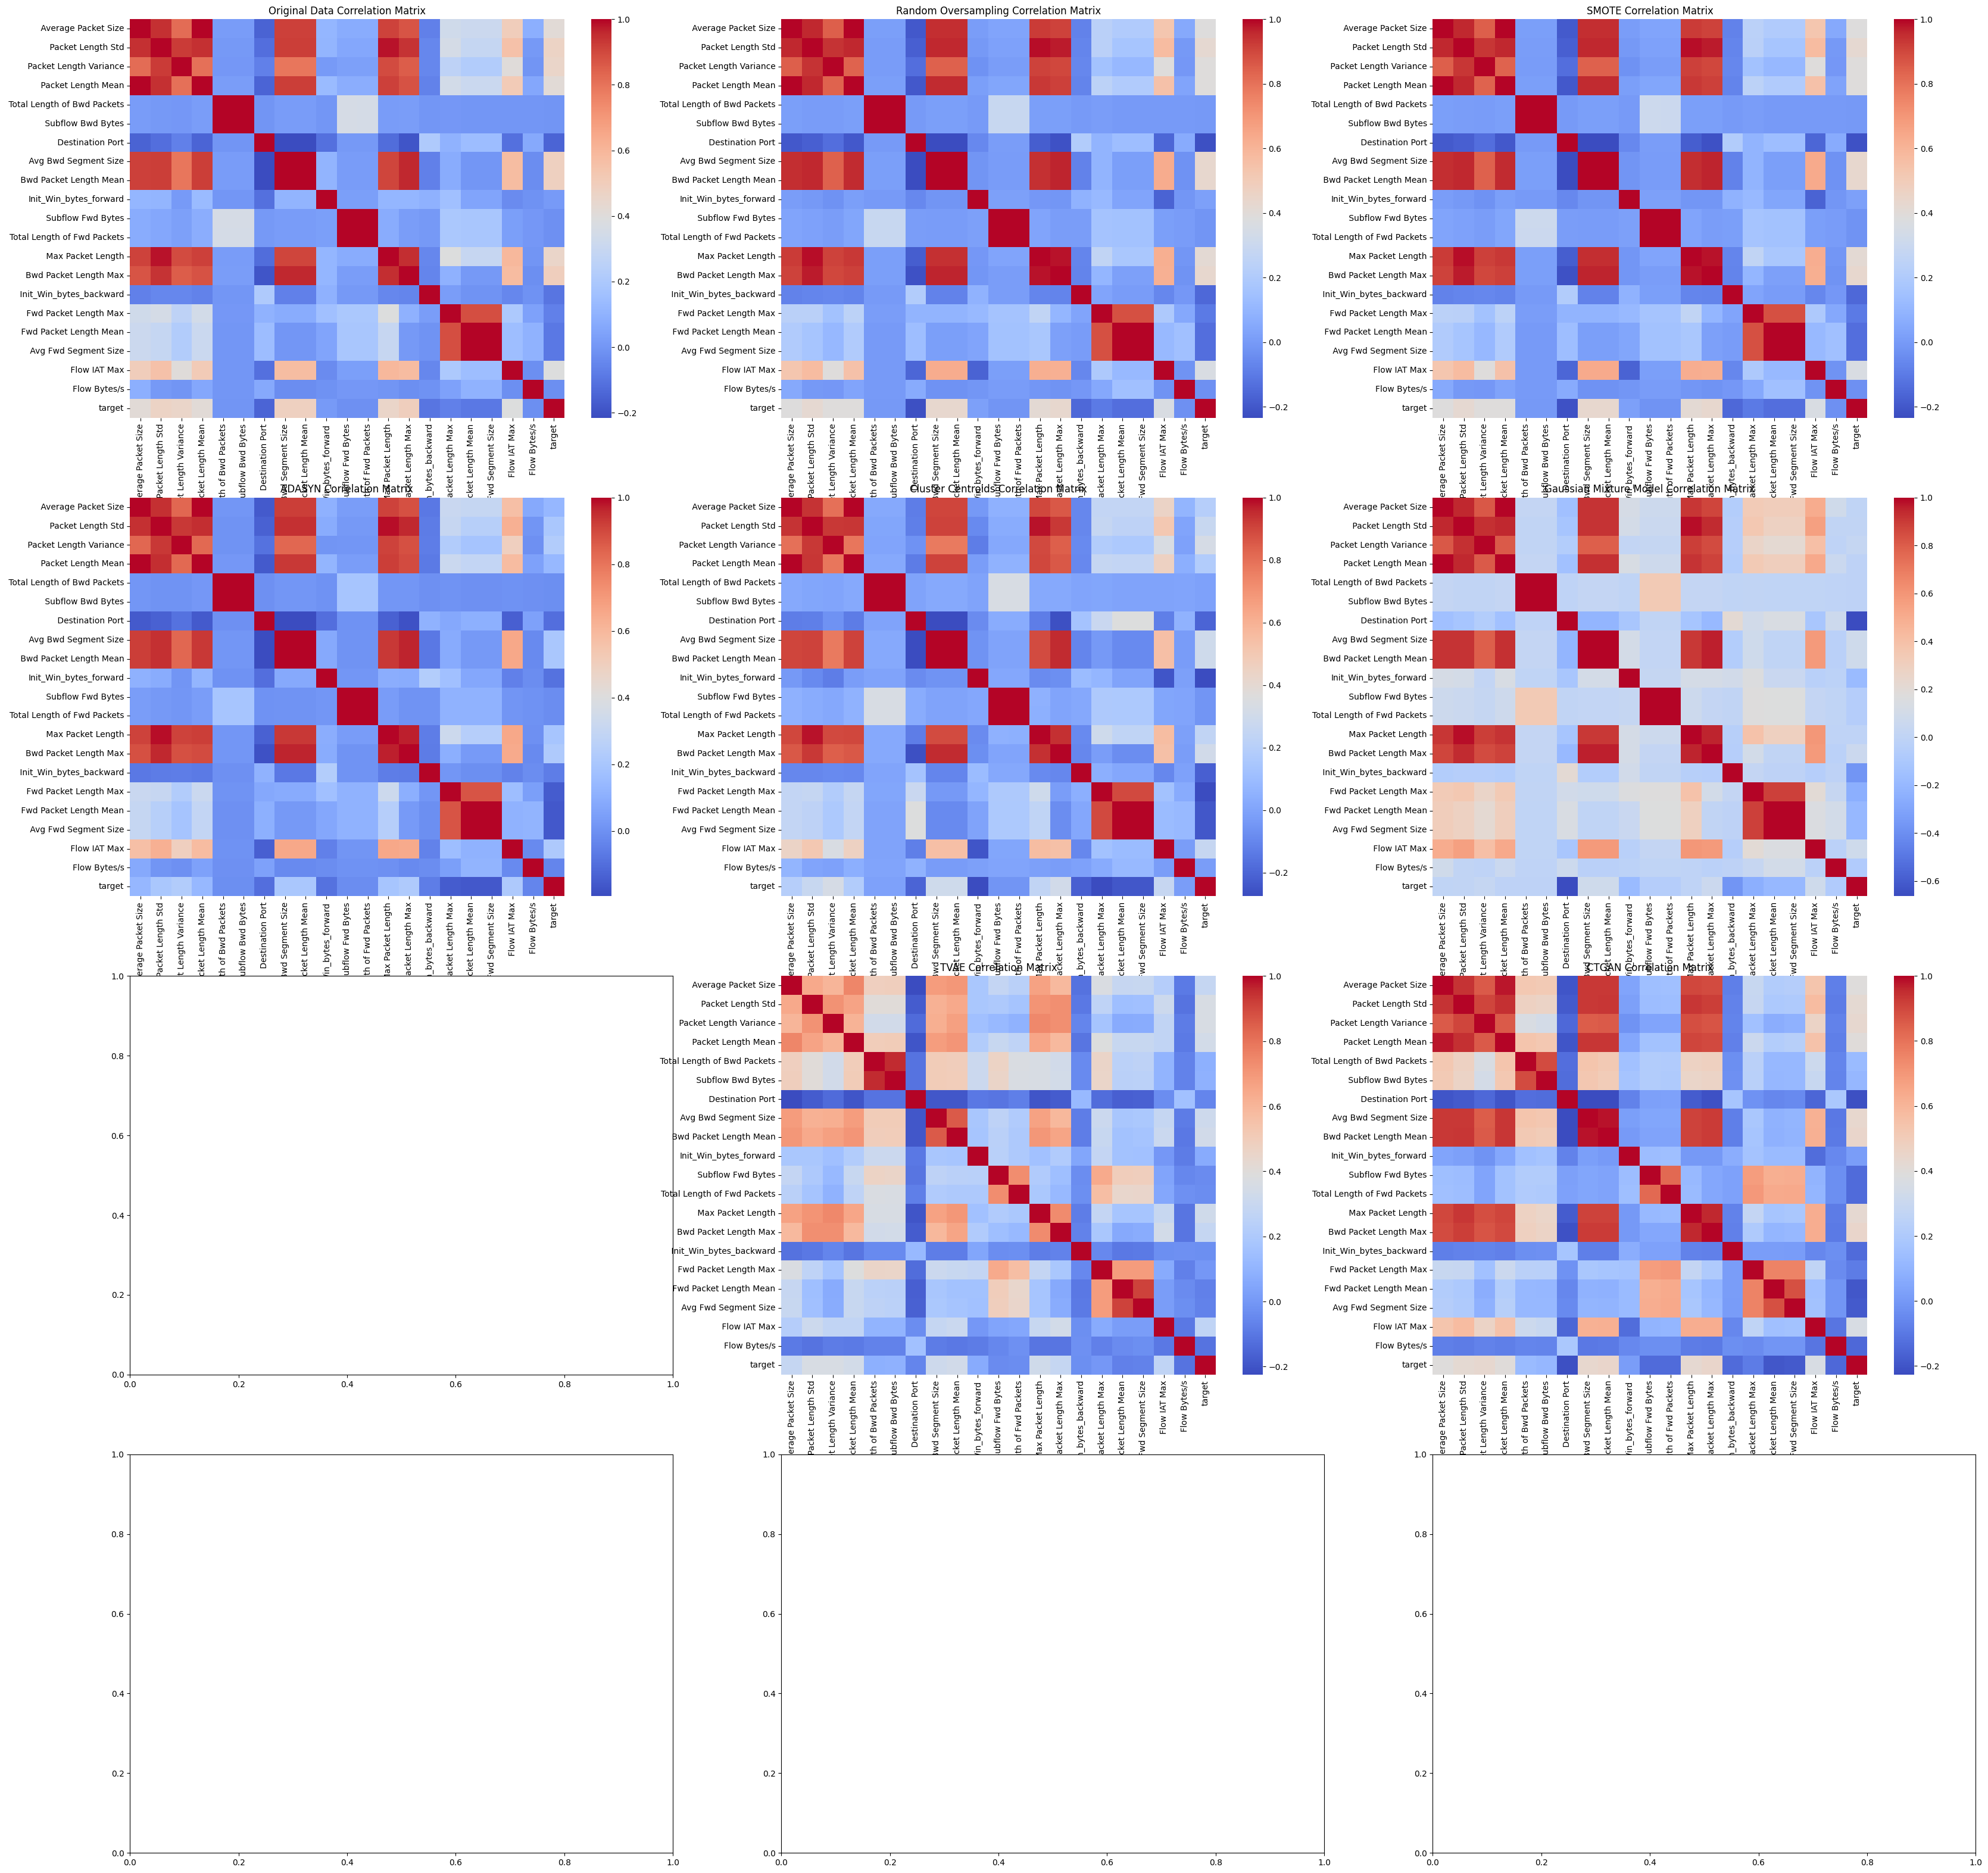

In [9]:
# Plot the correlation matrix of the original and all oversampled data
fig, axes = plt.subplots(4, 3, figsize=(40, 40))
sns.heatmap(data.corr(), ax=axes[0, 0], cmap="coolwarm", annot=False, xticklabels=data.corr().columns, yticklabels=data.corr().columns)
axes[0, 0].set_title("Original Data Correlation Matrix")
sns.heatmap(df_ros.corr(), ax=axes[0, 1], cmap="coolwarm", annot=False, xticklabels=df_ros.corr().columns, yticklabels=df_ros.corr().columns)
axes[0, 1].set_title("Random Oversampling Correlation Matrix")
sns.heatmap(df_smote.corr(), ax=axes[0, 2], cmap="coolwarm", annot=False, xticklabels=df_smote.corr().columns, yticklabels=df_smote.corr().columns)
axes[0, 2].set_title("SMOTE Correlation Matrix")
sns.heatmap(df_adasyn.corr(), ax=axes[1, 0], cmap="coolwarm", annot=False, xticklabels=df_adasyn.corr().columns, yticklabels=df_adasyn.corr().columns)
axes[1, 0].set_title("ADASYN Correlation Matrix")
sns.heatmap(df_cc.corr(), ax=axes[1, 1], cmap="coolwarm", annot=False, xticklabels=df_cc.corr().columns, yticklabels=df_cc.corr().columns)
axes[1, 1].set_title("Cluster Centroids Correlation Matrix")
sns.heatmap(df_gmm.corr(), ax=axes[1, 2], cmap="coolwarm", annot=False, xticklabels=df_gmm.corr().columns, yticklabels=df_gmm.corr().columns)
axes[1, 2].set_title("Gaussian Mixture Model Correlation Matrix")
#sns.heatmap(df_bn.corr(), ax=axes[2, 0], cmap="coolwarm", annot=False, xticklabels=df_bn.corr().columns, yticklabels=df_bn.corr().columns)
#axes[2, 0].set_title("Bayesian Network Correlation Matrix")
sns.heatmap(df_tvae.corr(), ax=axes[2, 1], cmap="coolwarm", annot=False, xticklabels=df_tvae.corr().columns, yticklabels=df_tvae.corr().columns)
axes[2, 1].set_title("TVAE Correlation Matrix")
sns.heatmap(df_ctgan.corr(), ax=axes[2, 2], cmap="coolwarm", annot=False, xticklabels=df_ctgan.corr().columns, yticklabels=df_ctgan.corr().columns)
axes[2, 2].set_title("CTGAN Correlation Matrix")
# sns.heatmap(df_ddmp.corr(), ax=axes[3, 0], cmap="coolwarm", annot=False, xticklabels=df_ddmp.corr().columns, yticklabels=df_ddmp.corr().columns)
# axes[3, 0].set_title("TABDDMP Correlation Matrix")
plt.show()

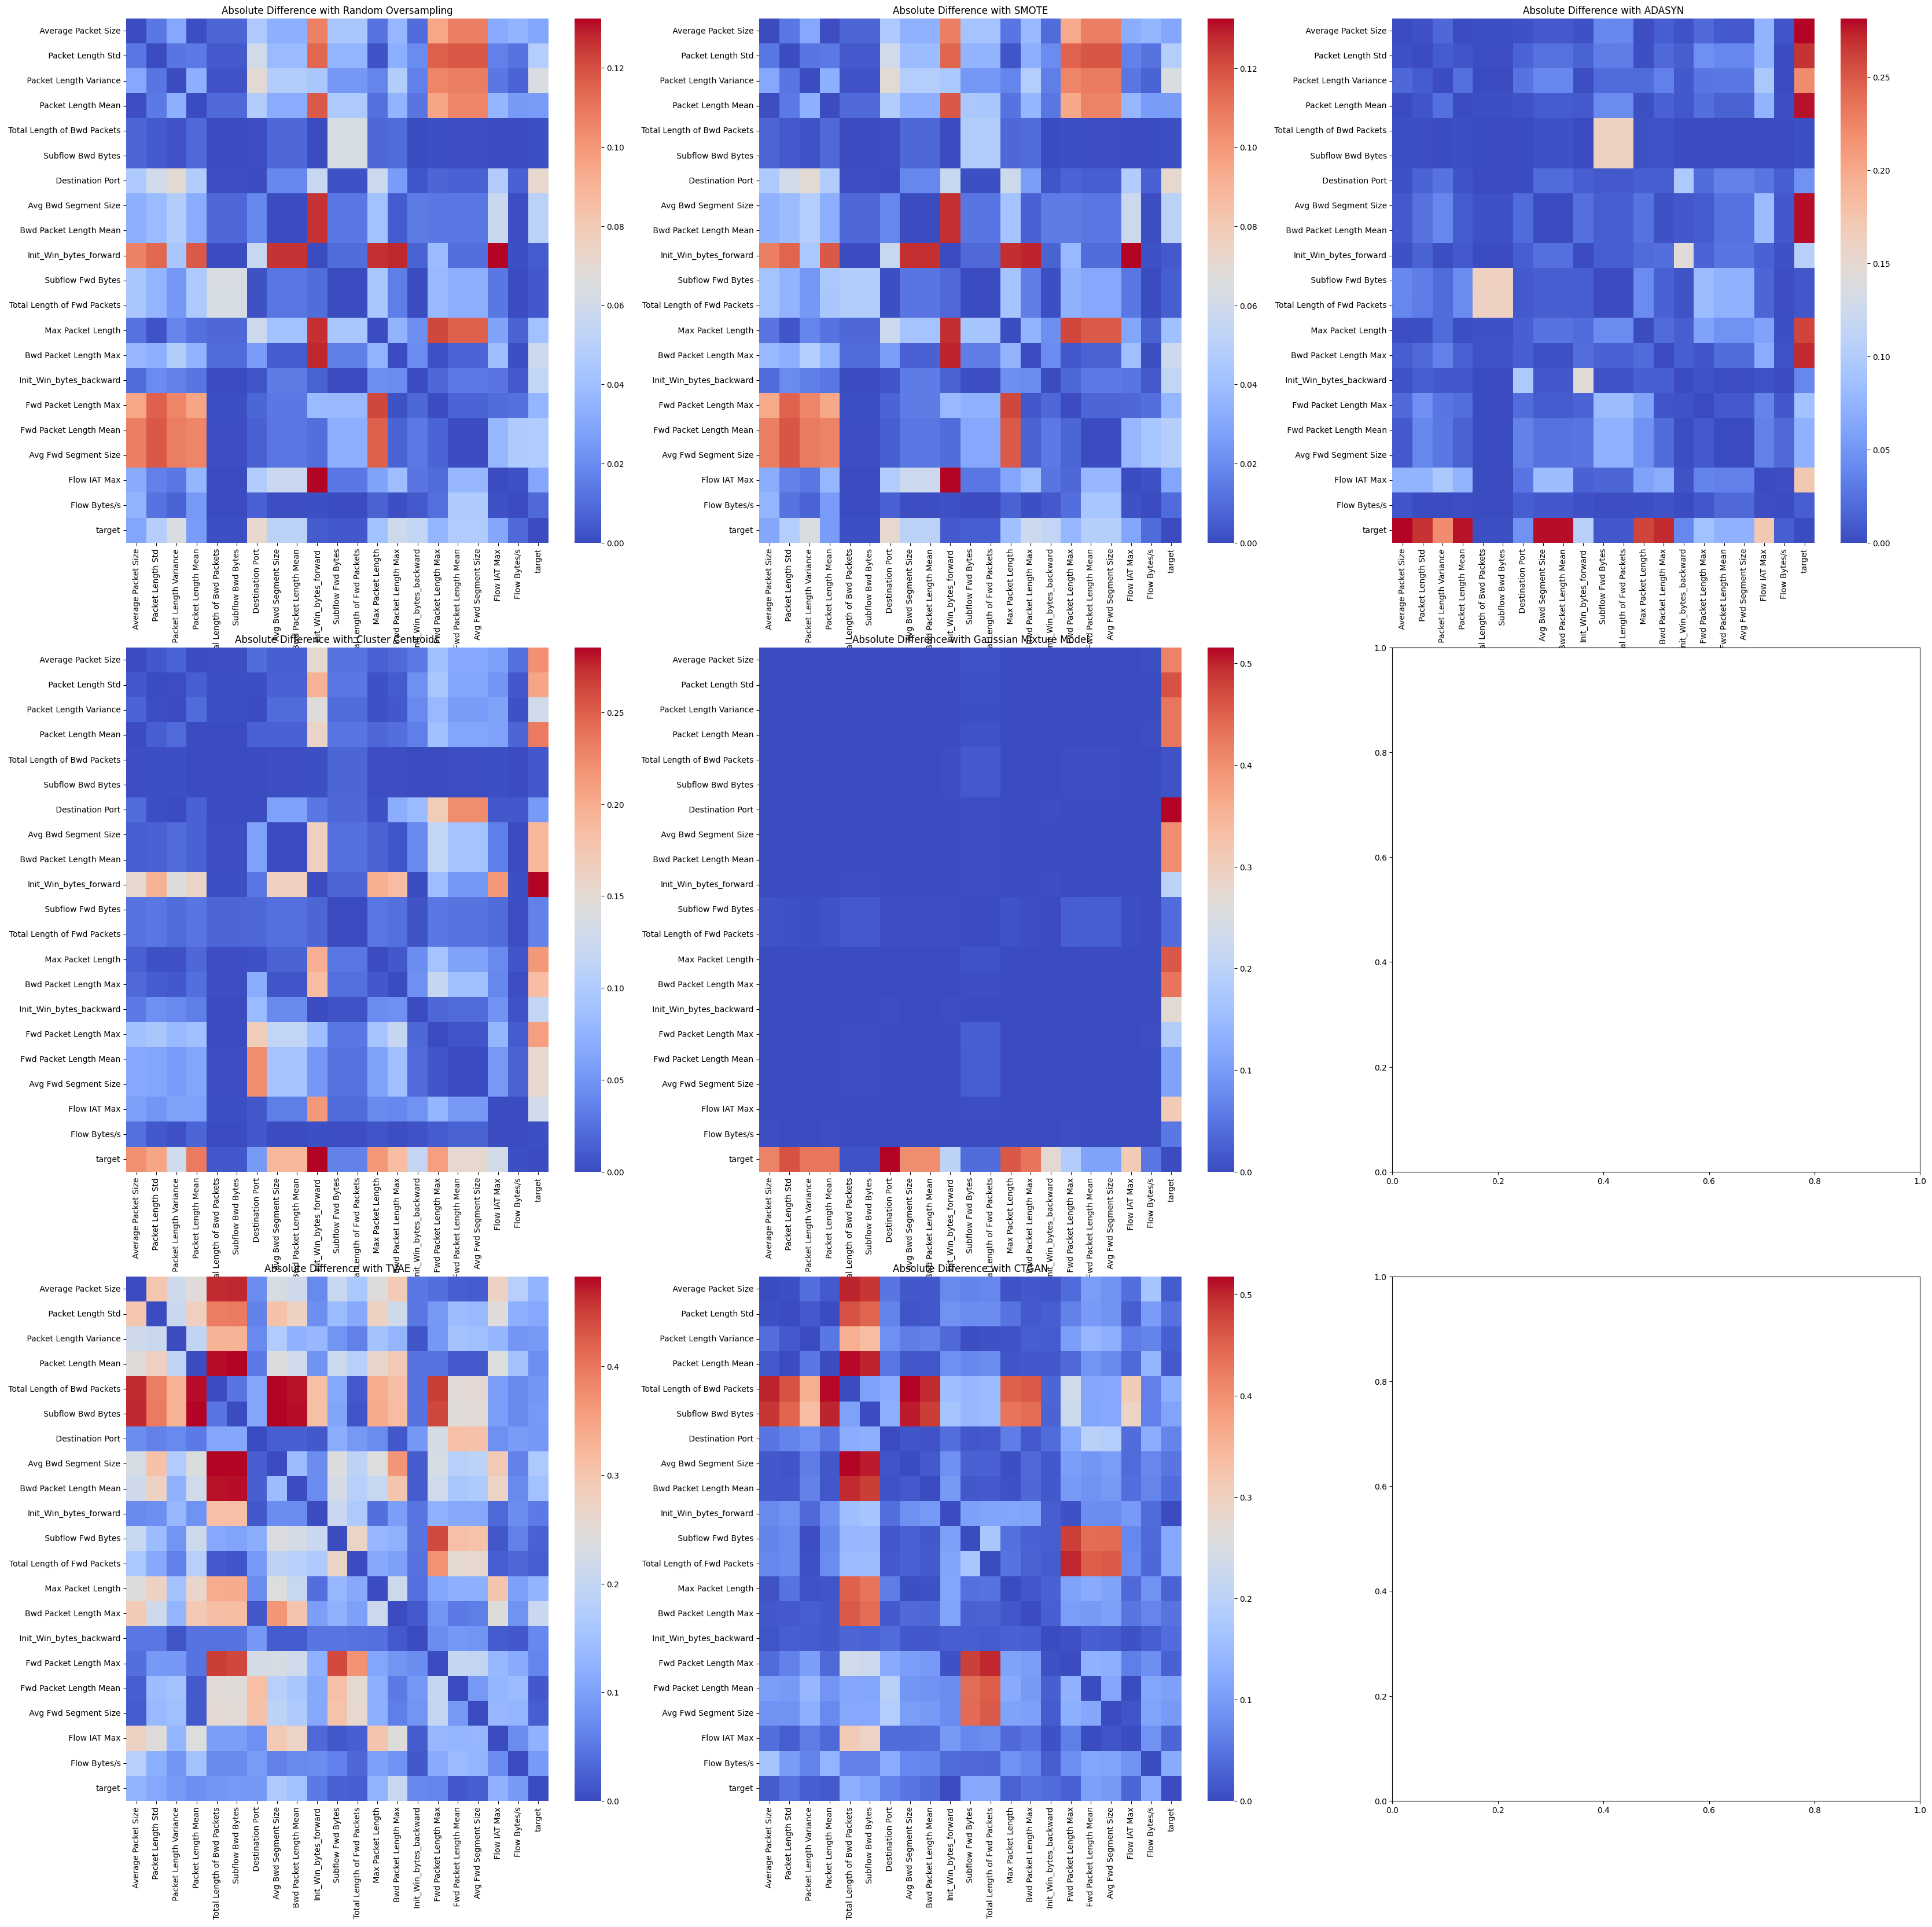

In [10]:
# Calculate the correlation matrices for the original and synthetic datasets
corr_original = data.corr()
corr_ros = df_ros.corr()
corr_smote = df_smote.corr()
corr_adasyn = df_adasyn.corr()
corr_cc = df_cc.corr()
corr_gmm = df_gmm.corr()
#corr_bn = df_bn.corr()
corr_tvae = df_tvae.corr()
corr_ctgan = df_ctgan.corr()
# corr_ddmp = df_ddmp.corr()

# Calculate the absolute difference matrices
abs_diff_ros = np.abs(corr_original - corr_ros)
abs_diff_smote = np.abs(corr_original - corr_smote)
abs_diff_adasyn = np.abs(corr_original - corr_adasyn)
abs_diff_cc = np.abs(corr_original - corr_cc)
abs_diff_gmm = np.abs(corr_original - corr_gmm)
#abs_diff_bn = np.abs(corr_original - corr_bn)
abs_diff_tvae = np.abs(corr_original - corr_tvae)
abs_diff_ctgan = np.abs(corr_original - corr_ctgan)
# abs_diff_ddmp = np.abs(corr_original - corr_ddmp)

# Plot the absolute difference heatmaps
fig, axes = plt.subplots(3, 3, figsize=(40, 40))
sns.heatmap(abs_diff_ros, ax=axes[0, 0], cmap="coolwarm", annot=False, xticklabels=abs_diff_ros.columns, yticklabels=abs_diff_ros.columns)
axes[0, 0].set_title("Absolute Difference with Random Oversampling")
sns.heatmap(abs_diff_smote, ax=axes[0, 1], cmap="coolwarm", annot=False, xticklabels=abs_diff_smote.columns, yticklabels=abs_diff_smote.columns)
axes[0, 1].set_title("Absolute Difference with SMOTE")
sns.heatmap(abs_diff_adasyn, ax=axes[0, 2], cmap="coolwarm", annot=False, xticklabels=abs_diff_adasyn.columns, yticklabels=abs_diff_adasyn.columns)
axes[0, 2].set_title("Absolute Difference with ADASYN")
sns.heatmap(abs_diff_cc, ax=axes[1, 0], cmap="coolwarm", annot=False, xticklabels=abs_diff_cc.columns, yticklabels=abs_diff_cc.columns)
axes[1, 0].set_title("Absolute Difference with Cluster Centroids")
sns.heatmap(abs_diff_gmm, ax=axes[1, 1], cmap="coolwarm", annot=False, xticklabels=abs_diff_gmm.columns, yticklabels=abs_diff_gmm.columns)
axes[1, 1].set_title("Absolute Difference with Gaussian Mixture Model")
#sns.heatmap(abs_diff_bn, ax=axes[1, 2], cmap="coolwarm", annot=False, xticklabels=abs_diff_bn.columns, yticklabels=abs_diff_bn.columns)
#axes[1, 2].set_title("Absolute Difference with Bayesian Network")
sns.heatmap(abs_diff_tvae, ax=axes[2, 0], cmap="coolwarm", annot=False, xticklabels=abs_diff_tvae.columns, yticklabels=abs_diff_tvae.columns)
axes[2, 0].set_title("Absolute Difference with TVAE")
sns.heatmap(abs_diff_ctgan, ax=axes[2, 1], cmap="coolwarm", annot=False, xticklabels=abs_diff_ctgan.columns, yticklabels=abs_diff_ctgan.columns)
axes[2, 1].set_title("Absolute Difference with CTGAN")
# sns.heatmap(abs_diff_ddmp, ax=axes[2, 2], cmap="coolwarm", annot=False, xticklabels=abs_diff_ddmp.columns, yticklabels=abs_diff_ddmp.columns)
# axes[2, 2].set_title("Absolute Difference with TABDDMP")
plt.show()



--- Average Results ---
Original Data:
Equal Distributions: 20
Different Distributions: 0
Average KS P-value: 1.0
-----------------------------
Random Oversampling:
Equal Distributions: 0
Different Distributions: 20
Average KS P-value: 0.0
-----------------------------
SMOTE:
Equal Distributions: 0
Different Distributions: 20
Average KS P-value: 0.0
-----------------------------
ADASYN:
Equal Distributions: 0
Different Distributions: 20
Average KS P-value: 0.0
-----------------------------
Cluster Centroids:
Equal Distributions: 0
Different Distributions: 20
Average KS P-value: 0.0
-----------------------------
Gaussian Mixture Model:
Equal Distributions: 0
Different Distributions: 20
Average KS P-value: 0.0
-----------------------------
TVAE:
Equal Distributions: 0
Different Distributions: 20
Average KS P-value: 0.0
-----------------------------
CTGAN:
Equal Distributions: 0
Different Distributions: 20
Average KS P-value: 0.0
-----------------------------


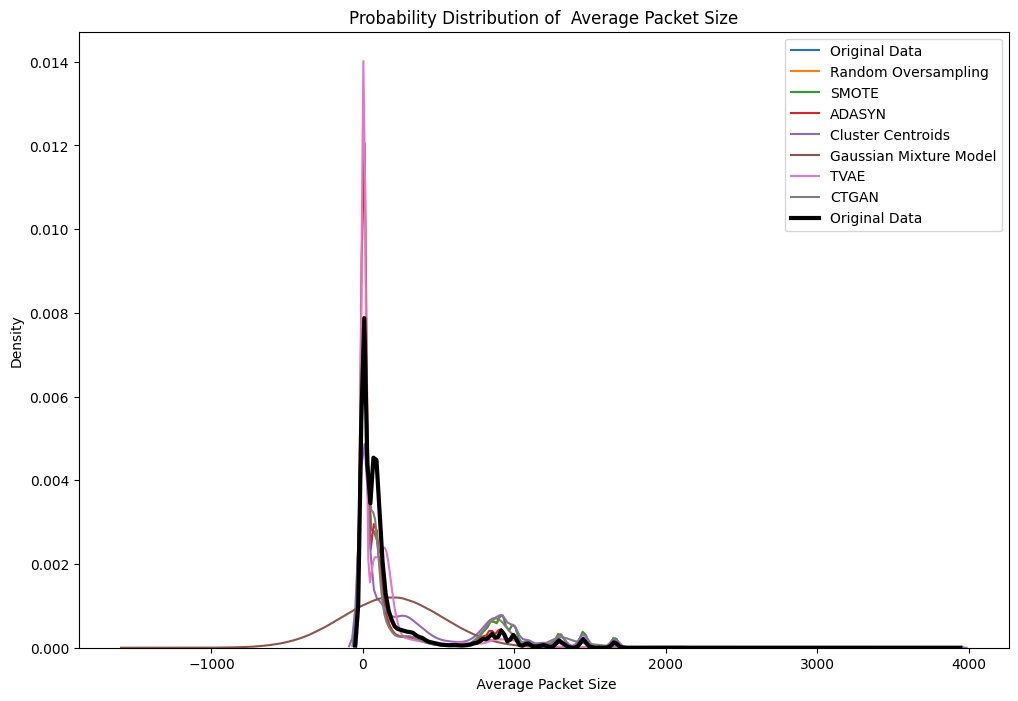

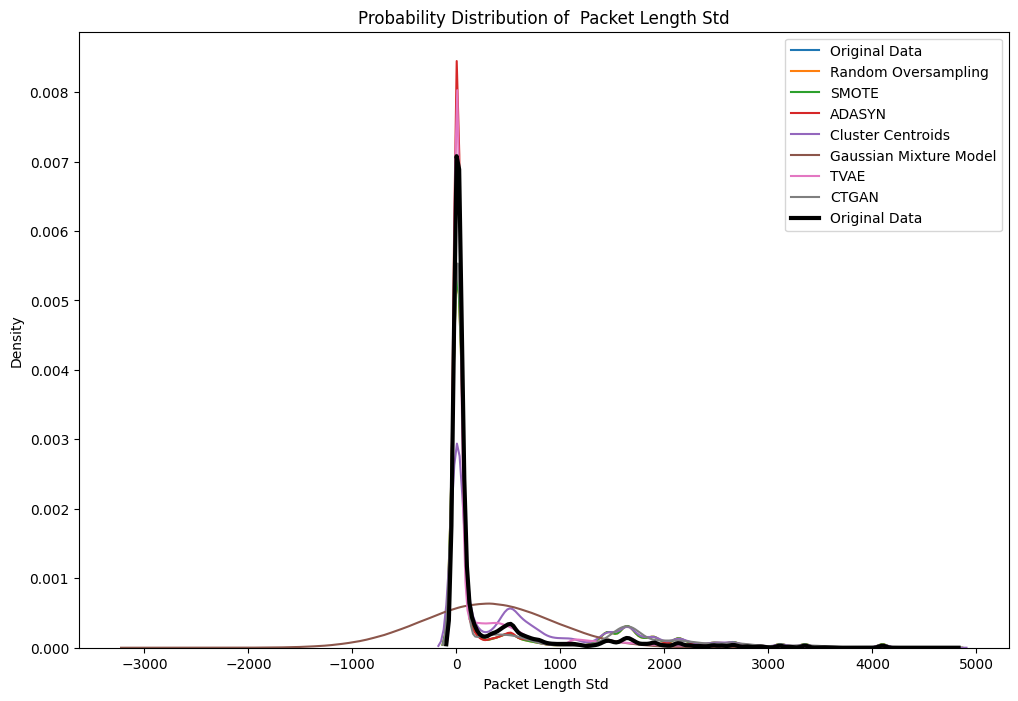

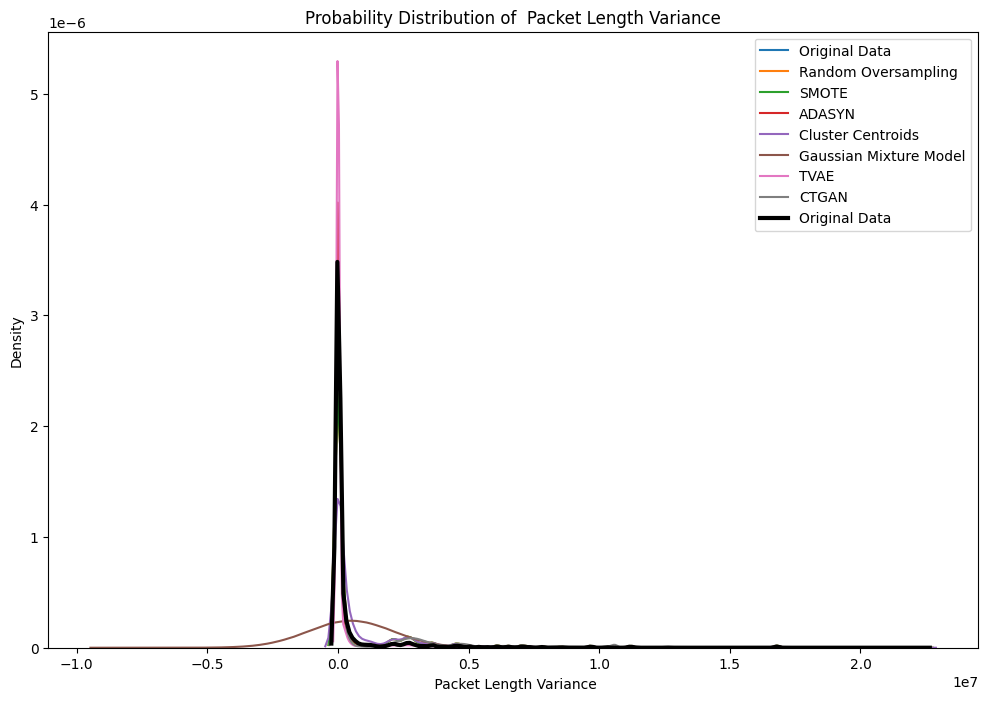

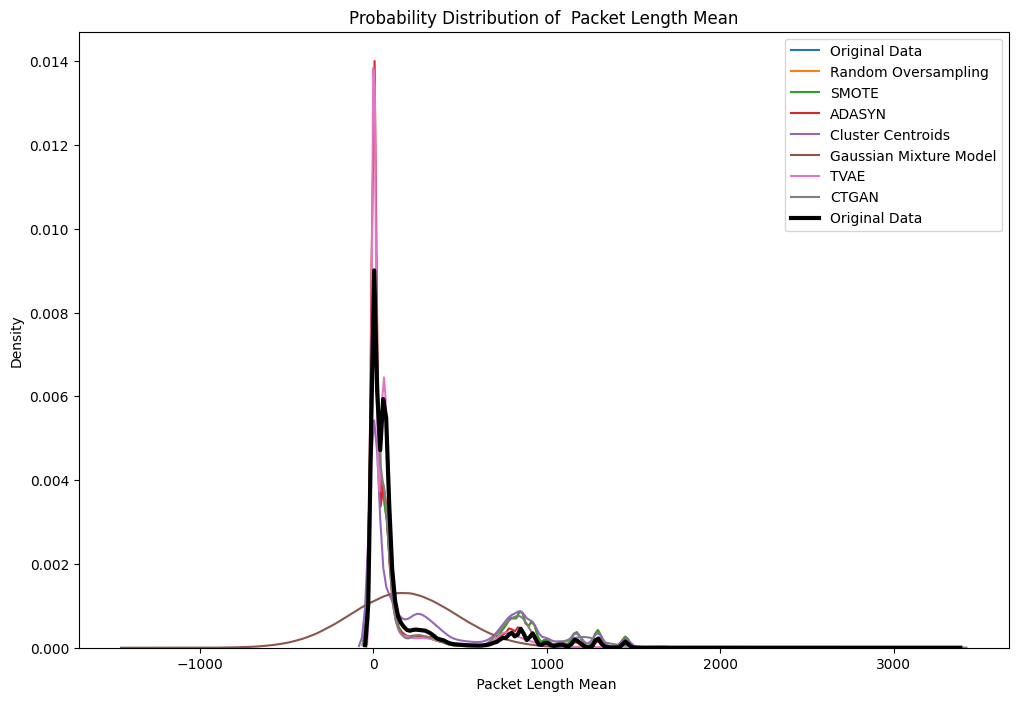

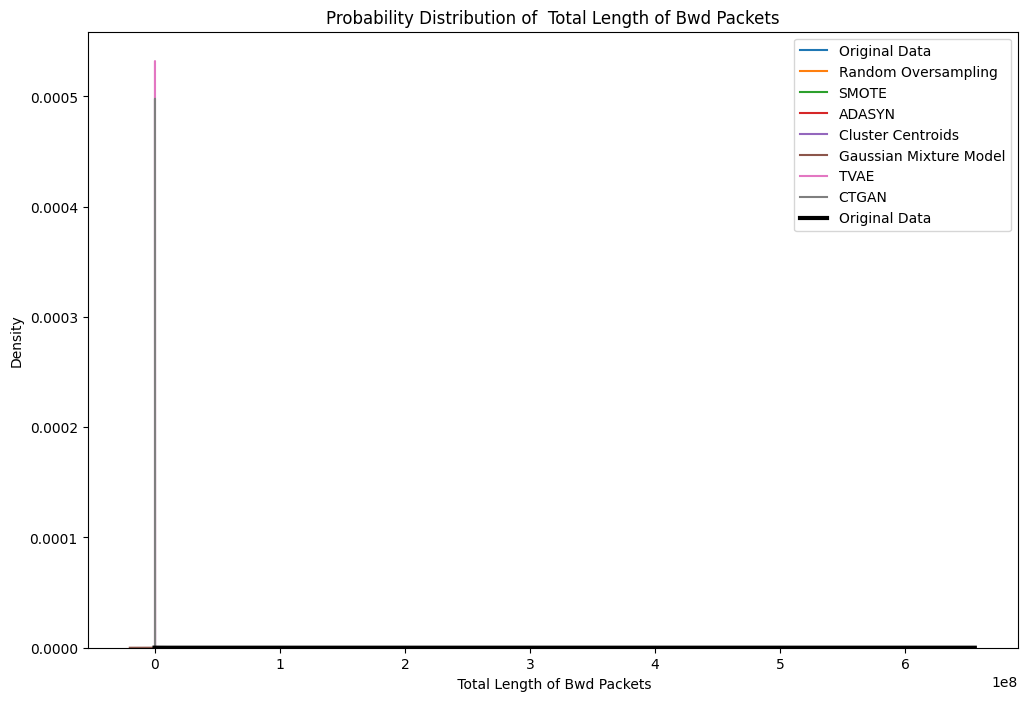

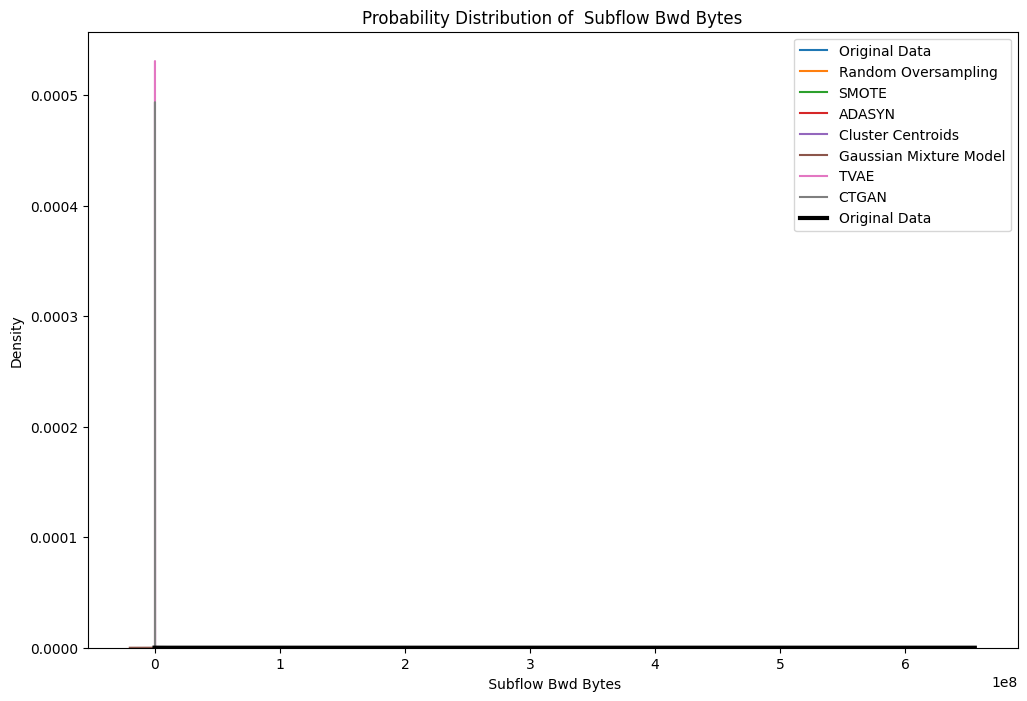

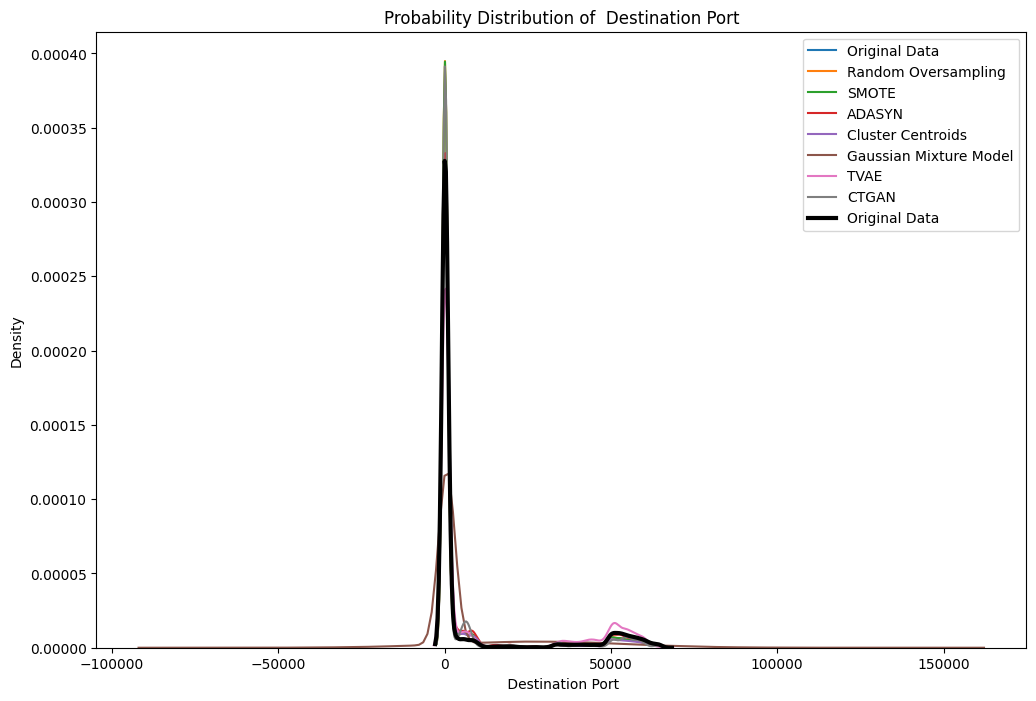

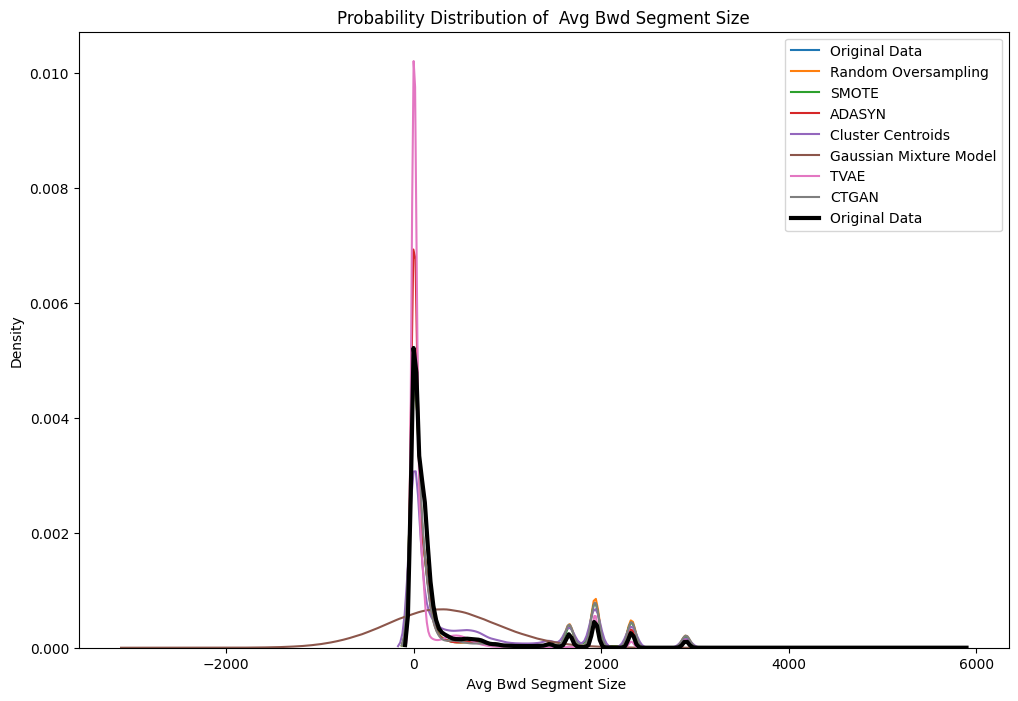

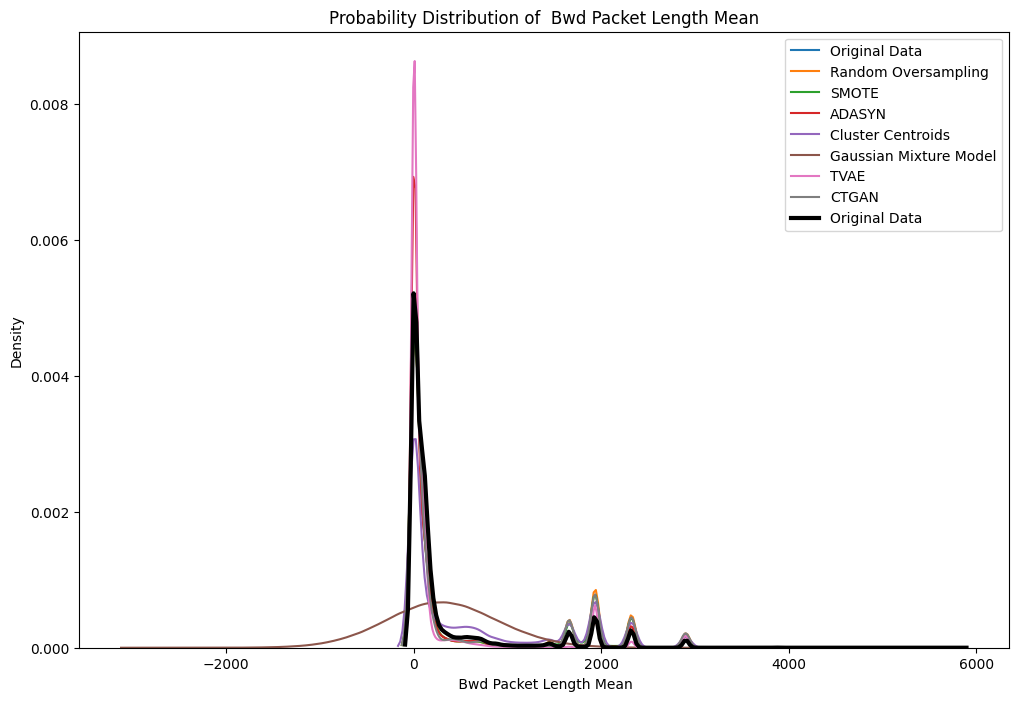

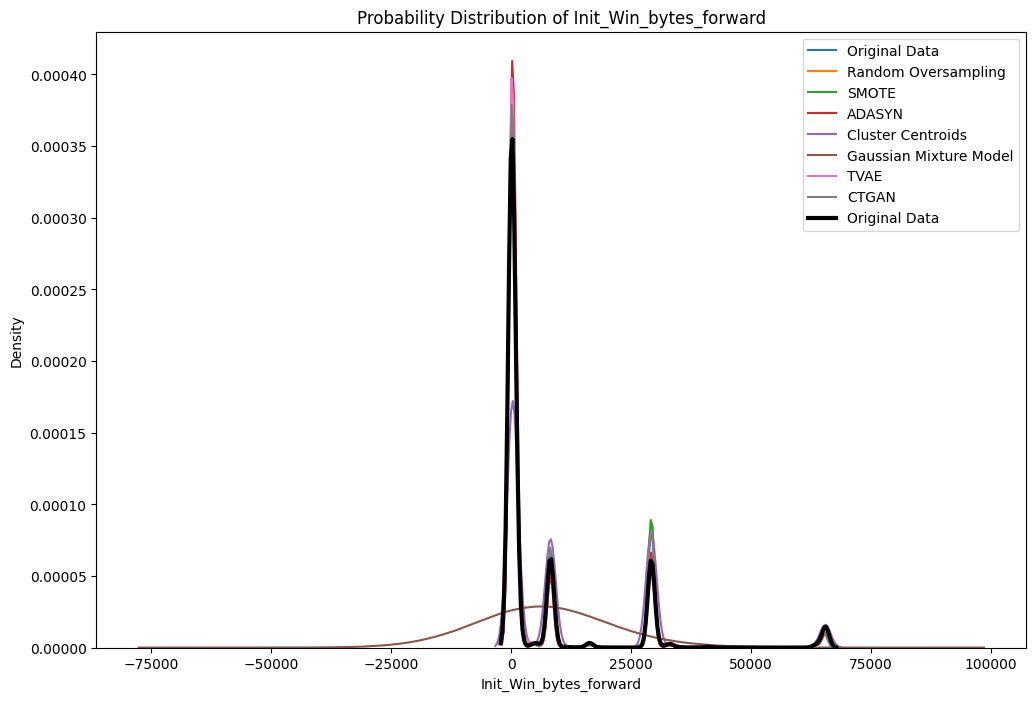

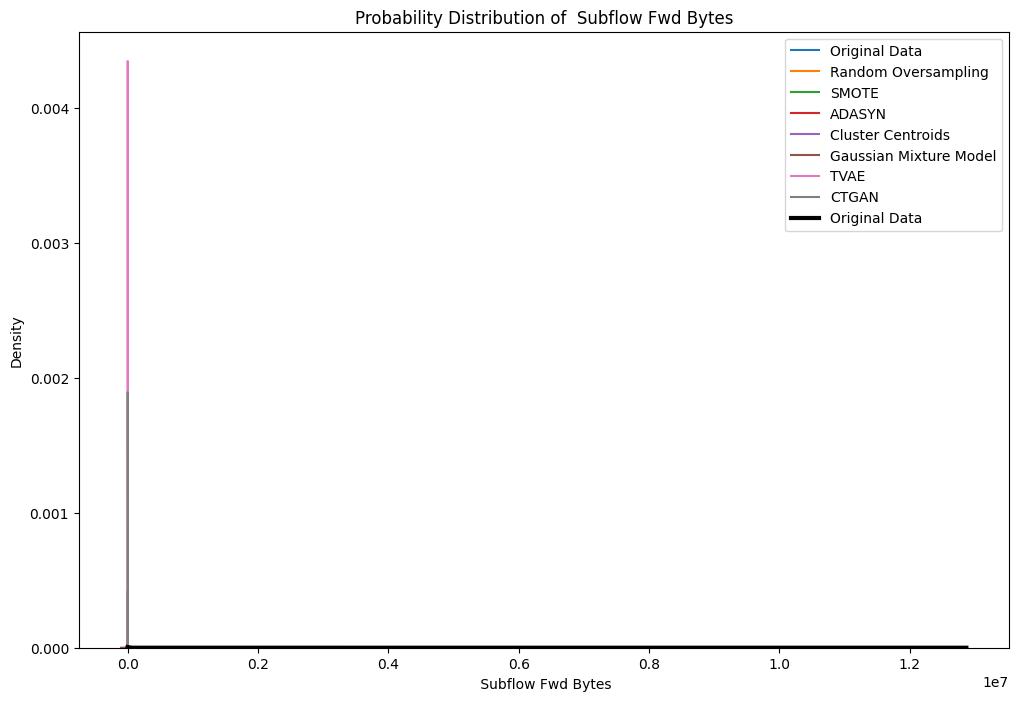

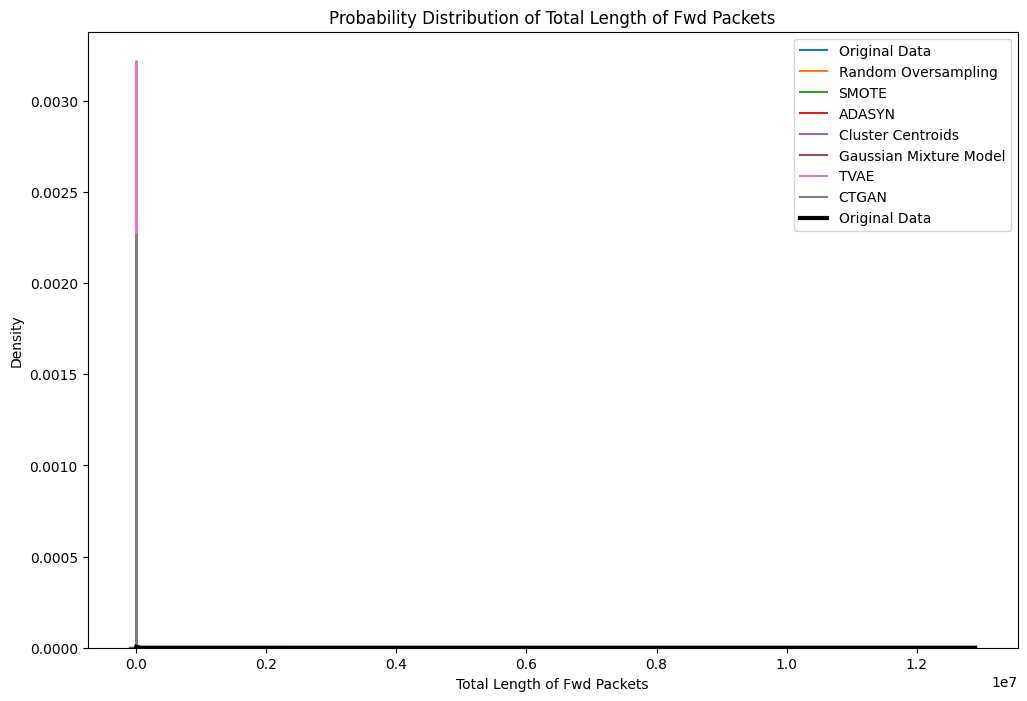

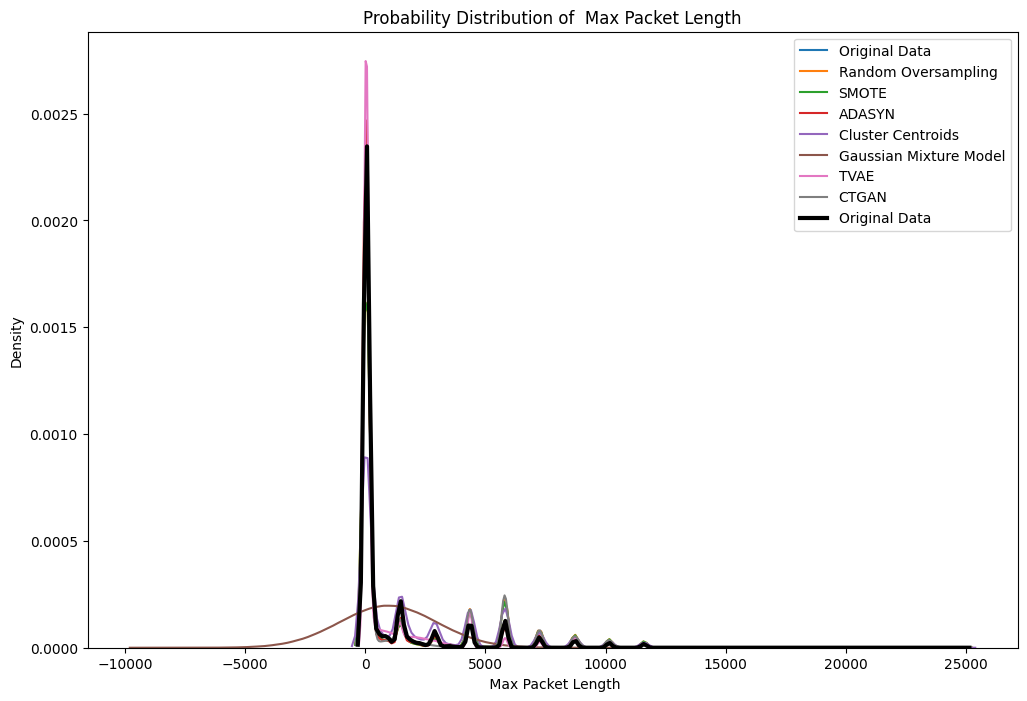

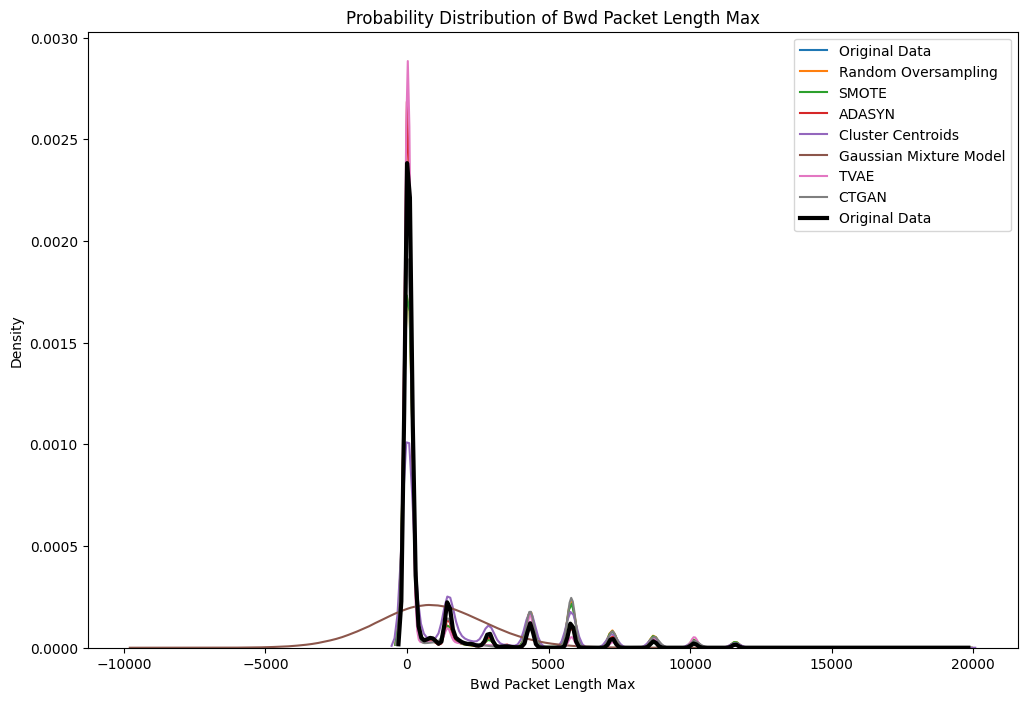

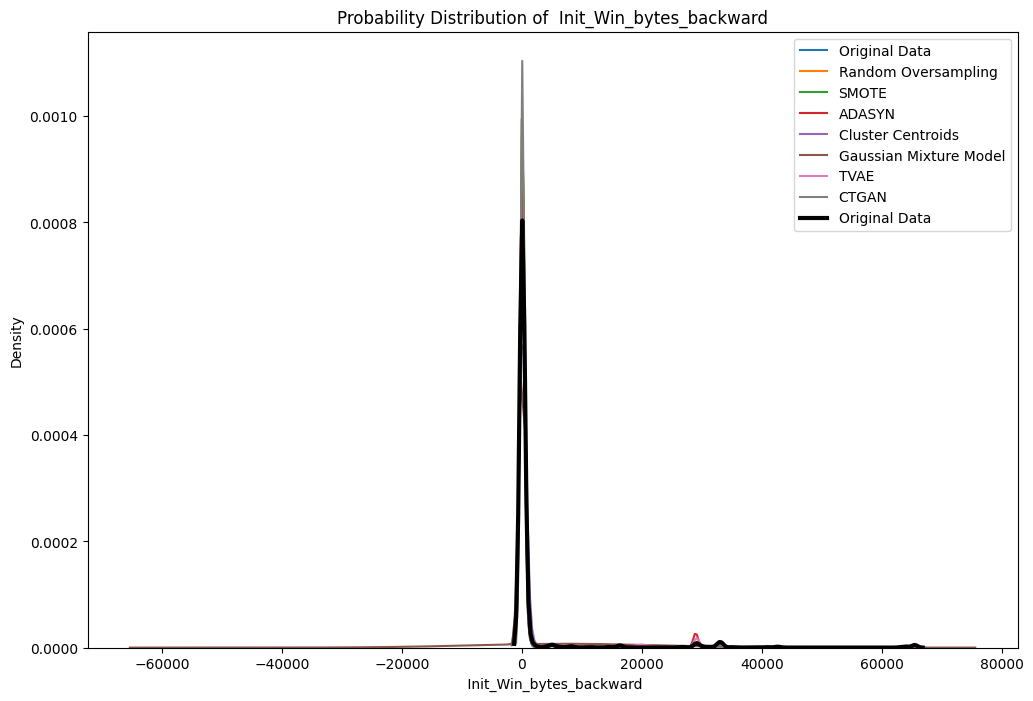

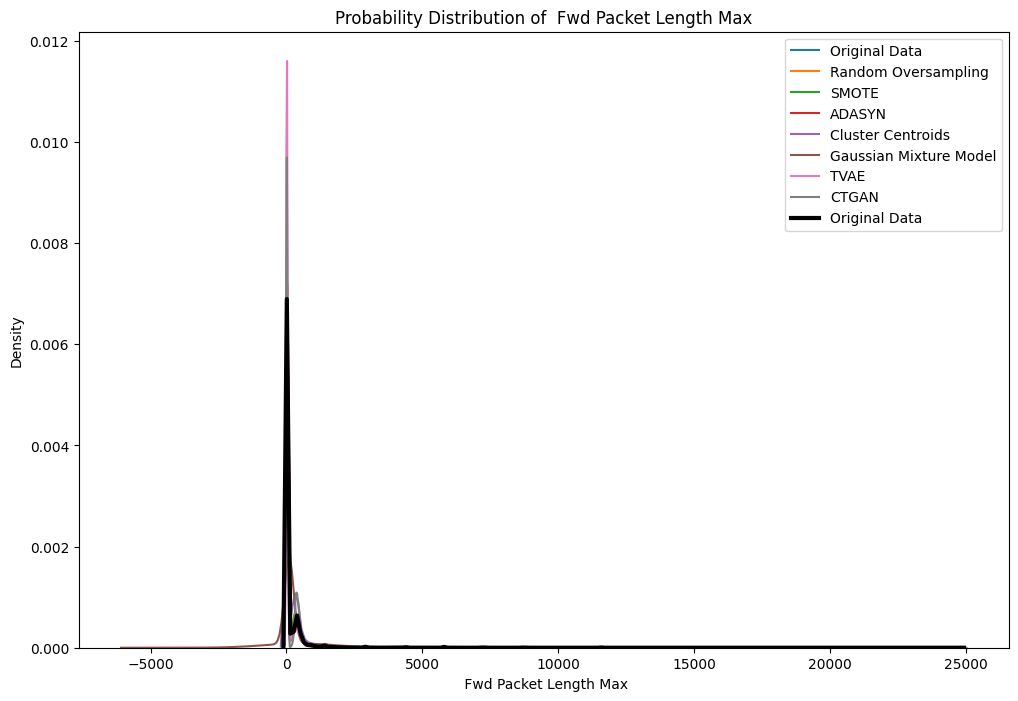

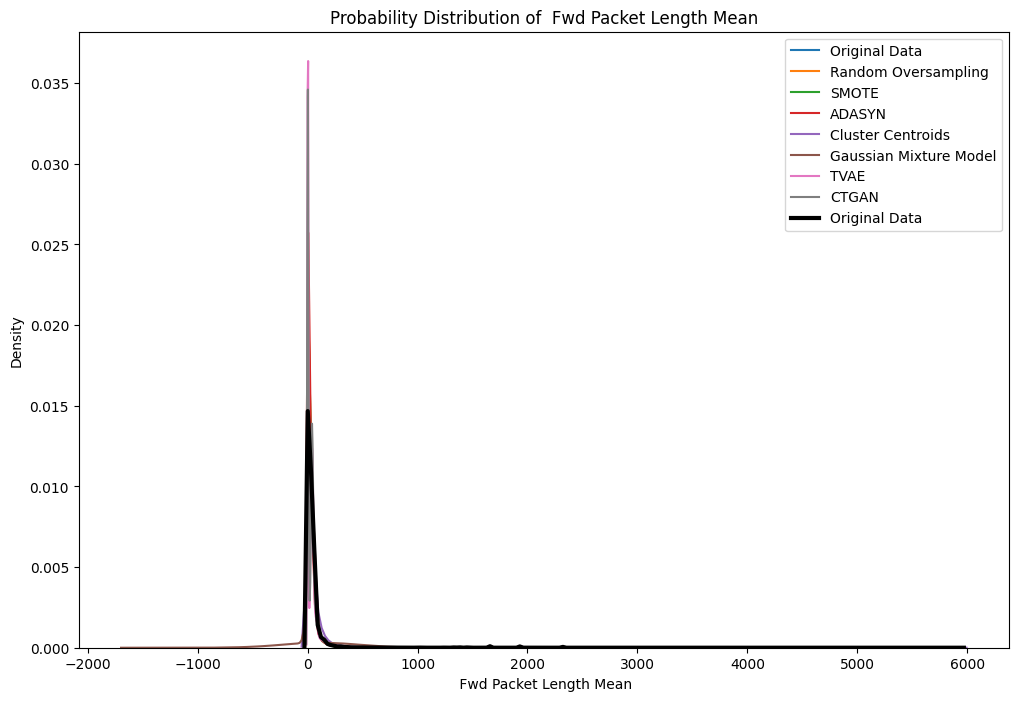

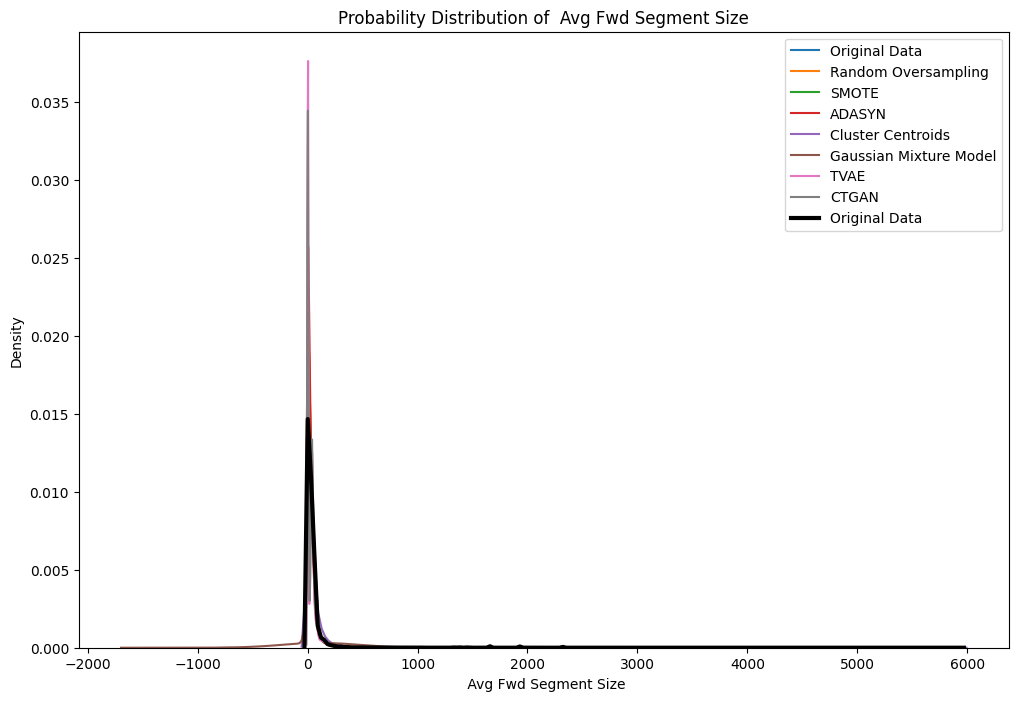

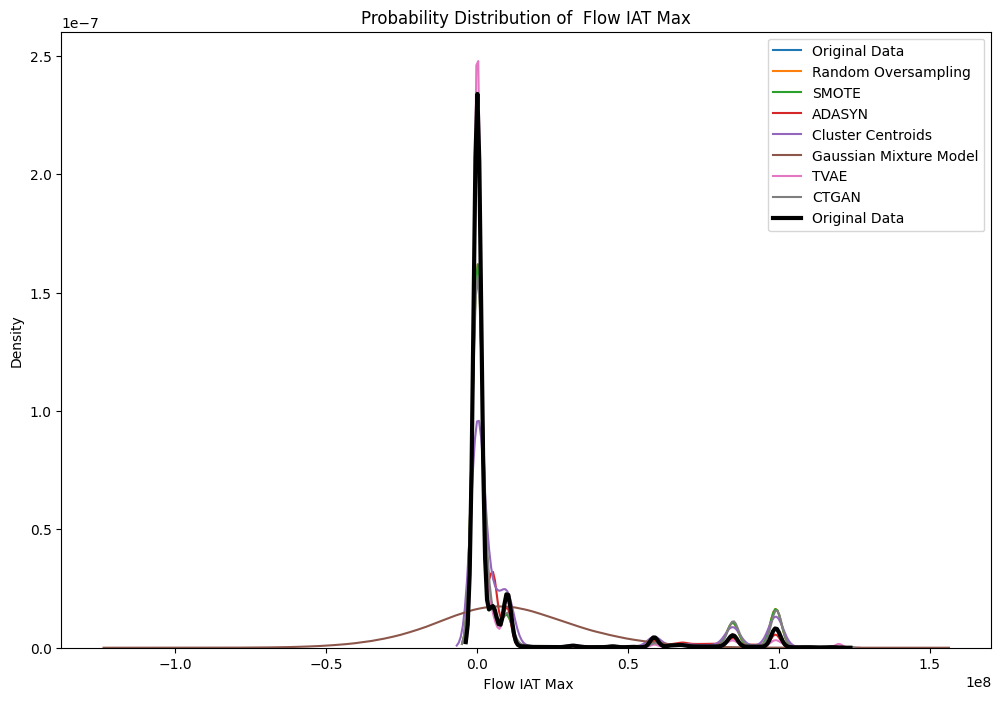

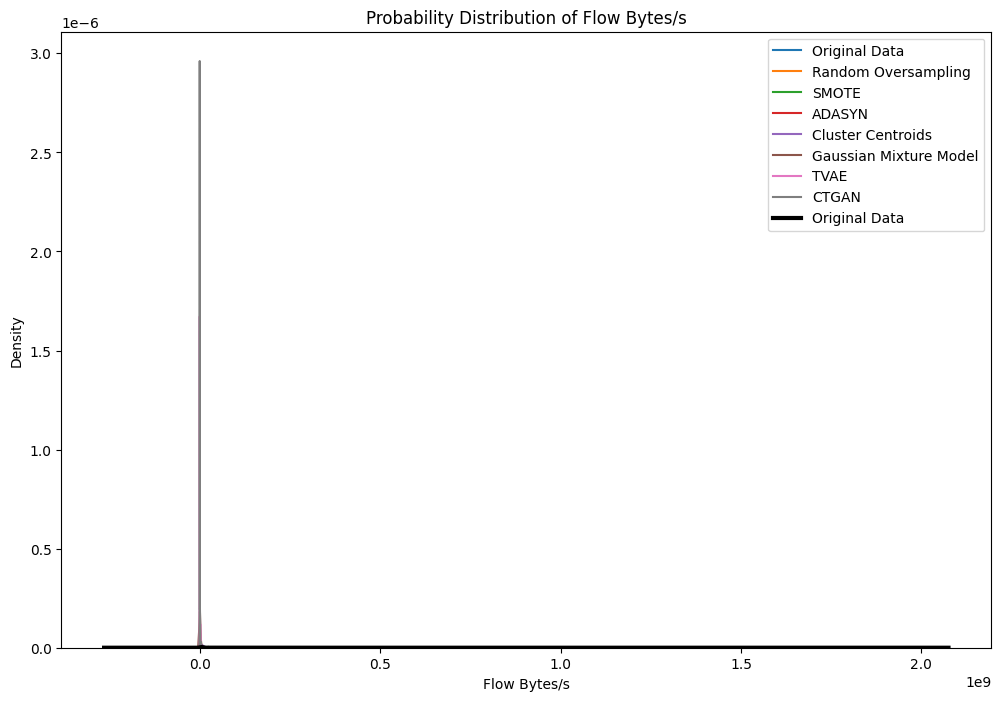

In [11]:

# List of DataFrames
dfs = [data, df_ros, df_smote, df_adasyn, df_cc, df_gmm, df_tvae, df_ctgan]
titles = ["Original Data", "Random Oversampling", "SMOTE", "ADASYN", "Cluster Centroids", 
          "Gaussian Mixture Model", "TVAE", "CTGAN"]

# Function to compare distributions and calculate KS test results
def compare_distributions(real_data, synthetic_datasets, titles):
    results = {}
    average_results = {}
    
    for synthetic_data, title in zip(synthetic_datasets, titles):
        
        ks_results = []
        
        equal_count = 0
        different_count = 0
        
        for column in real_data.columns:
            if column == 'target':
                continue
            
            real_values = real_data[column].values
            synthetic_values = synthetic_data[column].values
            
            # Perform KS Test
            ks_statistic, ks_p_value = ks_2samp(real_values, synthetic_values)
            
            # Store KS test results
            ks_results.append({
                'Feature': column,
                'KS Statistic': ks_statistic,
                'KS P-value': ks_p_value
            })
            
            # Count equal and different distributions
            if ks_p_value > 0.05:
                equal_count += 1
            else:
                different_count += 1
        
        # Store results for current synthetic dataset
        results[title] = ks_results
        
        # Calculate average results
        total_features = len(real_data.columns) - 1  # excluding target column
        average_results[title] = {
            'Equal Distributions': equal_count,
            'Different Distributions': different_count,
            'Average KS P-value': np.mean([result['KS P-value'] for result in ks_results])
        }
    
    # Print average results
    print("\n--- Average Results ---")
    for title, avg_res in average_results.items():
        print(f"{title}:")
        print(f"Equal Distributions: {avg_res['Equal Distributions']}")
        print(f"Different Distributions: {avg_res['Different Distributions']}")
        print(f"Average KS P-value: {avg_res['Average KS P-value']}")
        print("-----------------------------")
    
    return results, average_results

# Function to plot KDE plots for all features across all datasets
def plot_kde_comparison(real_data, synthetic_datasets, titles, ks_results):
    num_datasets = len(synthetic_datasets) + 1  # including original data
    num_features = len(real_data.columns) - 1  # excluding target column
    
    for column in real_data.columns:
        if column == 'target':
            continue
        
        plt.figure(figsize=(12, 8))
        for i, synthetic_data in enumerate(synthetic_datasets):
            sns.kdeplot(synthetic_data[column], label=titles[i])
        
        sns.kdeplot(real_data[column], label='Original Data', linewidth=3, color='black')
        
        # Annotate KS test results on the plot
        #for result in ks_results:
         #   ks_statistic = result['KS Statistic']
          #  ks_p_value = result['KS P-value']
           # if ks_p_value > 0.05:
            #    plt.text(0.98, 0.95 - ks_results.index(result)*0.05, f'{result["Feature"]}: KS p-value={ks_p_value:.3f}', transform=plt.gca().transAxes, ha='right', color='green')
            #else:
             #   plt.text(0.98, 0.95 - ks_results.index(result)*0.05, f'{result["Feature"]}: KS p-value={ks_p_value:.3f}', transform=plt.gca().transAxes, ha='right', color='red')
        
        plt.title(f'Probability Distribution of {column}')
        plt.legend()
        plt.show()

# Example usage
# Assuming `dfs`, `titles`, and `df` are defined as before
results, average_results = compare_distributions(data, dfs, titles)
plot_kde_comparison(data, dfs, titles, results[titles[1]])  # Display for one synthetic dataset (change index as needed)


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, f1

# Initialize results dictionary
utility_results = {title: {'TRTR_accuracy': 0, 'TRTR_f1': 0, 'TSTR_accuracy': 0, 'TSTR_f1': 0} for title in titles[1:]}

# Evaluate TRTR (Training on Real, Testing on Real)
model_trtr = RandomForestClassifier(random_state=42)
model_trtr.fit(X_train, y_train)
trtr_accuracy, trtr_f1 = evaluate_model(model_trtr, X_test, y_test)
utility_results["Original Data"] = {'TRTR_accuracy': trtr_accuracy, 'TRTR_f1': trtr_f1}

# Evaluate TSTR (Training on Synthetic, Testing on Real)
for i, data in enumerate(dfs[1:], 1):
    X_synthetic = data.drop('target', axis=1)
    y_synthetic = data['target']
    model_tstr = RandomForestClassifier(random_state=42)
    model_tstr.fit(X_synthetic, y_synthetic)
    tstr_accuracy, tstr_f1 = evaluate_model(model_tstr, X_test, y_test)
    utility_results[titles[i]]['TSTR_accuracy'] = tstr_accuracy
    utility_results[titles[i]]['TSTR_f1'] = tstr_f1

# Display the utility results
utility_df = pd.DataFrame(utility_results).T
print("Utility results (F1 score, accuracy comparison of TRTR and TSTR) for all datasets:")
print(utility_df)


Utility results (F1 score, accuracy comparison of TRTR and TSTR) for all datasets:
                        TRTR_accuracy   TRTR_f1  TSTR_accuracy   TSTR_f1
Random Oversampling          0.000000  0.000000       0.997844  0.997845
SMOTE                        0.000000  0.000000       0.997503  0.997506
ADASYN                       0.000000  0.000000       0.996773  0.996781
Cluster Centroids            0.000000  0.000000       0.993002  0.993046
Gaussian Mixture Model       0.000000  0.000000       0.450832  0.474810
TVAE                         0.000000  0.000000       0.972053  0.972290
CTGAN                        0.000000  0.000000       0.960407  0.960852
Original Data                0.997838  0.997838            NaN       NaN


In [13]:
data.head()

,Average Packet Size,Packet Length Std,Packet Length Variance,Packet Length Mean,Total Length of Bwd Packets,Subflow Bwd Bytes,Destination Port,Avg Bwd Segment Size,Bwd Packet Length Mean,Init_Win_bytes_forward,...,Total Length of Fwd Packets,Max Packet Length,Bwd Packet Length Max,Init_Win_bytes_backward,Fwd Packet Length Max,Fwd Packet Length Mean,Avg Fwd Segment Size,Flow IAT Max,Flow Bytes/s,target
0,874.983519,3077.865971,1.031084e+07,796.577584,11471.0,9437.0,210.0,2920.722019,2922.757881,217.0,...,48.0,8716.0,8761.0,175.0,28.0,5.260500,4.213638,74498335.0,1050.273378,1
1,0.000000,0.018245,2.757686e+02,0.000000,0.0,0.0,292.0,0.000000,0.000000,208.0,...,0.0,0.0,0.0,226.0,0.0,0.000000,0.000000,34047.0,-2797.838215,0
2,254.474118,395.254060,2.061832e+05,330.455836,5575.0,7438.0,624.0,1394.868767,539.503872,64913.0,...,1450.0,1447.0,1457.0,5060.0,464.0,82.249081,290.997897,57556.0,64905.940918,0
3,25.095304,27.818680,4.699752e+02,43.467282,38.0,209.0,115.0,77.382145,39.790883,23.0,...,75.0,84.0,74.0,-1.0,36.0,38.553551,37.938525,19058311.0,858.469169,0
4,871.688630,1644.769445,2.220756e+06,913.939469,8154.0,9178.0,173.0,1480.117867,1373.911786,-1.0,...,511.0,4339.0,4342.0,238.0,537.0,75.730072,99.665491,86034667.0,4892.149570,1


In [15]:
dfs = [data, df_ros, df_smote, df_adasyn, df_cc, df_gmm, df_tvae, df_ctgan]
titles = ["Original Data", "Random Oversampling", "SMOTE", "ADASYN", "Cluster Centroids", 
          "Gaussian Mixture Model", "TVAE", "CTGAN"]

for title, df in zip(titles, dfs):
    #print(f"DataFrame: {title}")
    #print(df.logged_in.value_counts())
    #print(df.protocol_type_icmp.value_counts())
    #print(df.protocol_type_tcp.value_counts())
    #print(df.service_http.value_counts())
    #print(df.flag_S0.value_counts())
    #print(df.flag_SF.value_counts())
    print(df.target.value_counts())
    print("\n")  # Add a newline for better readability between DataFrames


target
0    1487910
1    1339966
Name: count, dtype: int64


target
0    1589924
1    1589924
Name: count, dtype: int64


target
0    1589924
1    1589924
Name: count, dtype: int64


target
0    1589924
1    1582954
Name: count, dtype: int64


target
0    389589
1    389589
Name: count, dtype: int64


target
1    1446213
0     533300
Name: count, dtype: int64


target
0    2396456
1     431420
Name: count, dtype: int64


target
0    1487910
1    1339966
Name: count, dtype: int64




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2827876 entries, 0 to 2827875
Data columns (total 21 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Average Packet Size          float64
 1    Packet Length Std            float64
 2    Packet Length Variance       float64
 3    Packet Length Mean           float64
 4    Total Length of Bwd Packets  float64
 5    Subflow Bwd Bytes            float64
 6    Destination Port             float64
 7    Avg Bwd Segment Size         float64
 8    Bwd Packet Length Mean       float64
 9   Init_Win_bytes_forward        float64
 10   Subflow Fwd Bytes            float64
 11  Total Length of Fwd Packets   float64
 12   Max Packet Length            float64
 13  Bwd Packet Length Max         float64
 14   Init_Win_bytes_backward      float64
 15   Fwd Packet Length Max        float64
 16   Fwd Packet Length Mean       float64
 17   Avg Fwd Segment Size         float64
 18   Flow IAT Max         